# Bike Share Analysis

## Background

[Motivate International](https://www.motivate-international.com/) is a bike-share systems operator based in New York City. They've made data about bike trips in Chicago [publicly available](https://divvy-tripdata.s3.amazonaws.com/index.html).

I'm not familiar with the offerings and internals of the company, so we'll work with a fictional scenario here. Let's say they offer single-ride passes, full-day passes, and annual memberships to customers. Riders opting for either single-ride or full-day passes are referred to as casual riders, while those opting for an annual membership are referred to as members.

## Objective

The goal here is to come up with marketing strategies aimed at converting casual riders to members. 

There is no personal information to directly contact target customers. So my idea here is to do broad outreach to casual riders, by putting up billboards for example. Since, presumably, there are limited marketing resources, I try to identify the places and times at which casual riders are most likely to come across these advertisments.

## Exploring the data

The dataset, made publicly available in the form of `.csv` files released monthly, contains information about bicycle trips in the city of Chicago. I'm working here with roughly twelve months of data, from October 30, 2024 to October 31, 2025. Let's take a quick look at some of the data items.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
trips = pd.read_csv("bike_trips.csv")

In [3]:
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,578DDD7CE1771FFA,classic_bike,2024-11-07 19:21:58.206,2024-11-07 19:28:57.301,Walsh Park,18067,Leavitt St & North Ave,TA1308000005,41.914610,-87.667968,41.910533,-87.682308,member
1,78B141C50102ABA6,classic_bike,2024-11-22 14:49:00.431,2024-11-22 14:56:15.475,Walsh Park,18067,Leavitt St & Armitage Ave,TA1309000029,41.914610,-87.667968,41.917805,-87.682437,member
2,1E794CF36394E2D7,classic_bike,2024-11-08 09:24:00.238,2024-11-08 09:28:33.480,Walsh Park,18067,Damen Ave & Cortland St,13133,41.914610,-87.667968,41.915983,-87.677335,member
3,E5DD2CAB58D73F98,classic_bike,2024-11-24 17:51:14.144,2024-11-24 18:05:32.574,Clark St & Elm St,TA1307000039,Clark St & Drummond Pl,TA1307000142,41.902973,-87.631280,41.931248,-87.644336,member
4,57F9878BC8C765F1,classic_bike,2024-11-04 14:59:16.032,2024-11-04 15:41:02.456,Clark St & Wellington Ave,TA1307000136,Streeter Dr & Grand Ave,13022,41.936497,-87.647539,41.892278,-87.612043,casual


Each row represents a single bike trip made between two docking stations.

Let's see what each column stands for

In [4]:
trips.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

- `ride_id` - A unique identifier for each trip
- `rideable_type` - The type of bicycle used, either `classic_bike` or `electric_bike`
- `startd_at` - The timestamp at which the ride began
- `ended_at` - The timestamp at which the ride ended
- `start_station_name` - The name of the docking station from which the ride began
- `start_station_id` - An identifier for the starting station
- `end_station_name` - The name of the docking station at which the ride ended
- `end_station_id` - An identifier for the ending station
- `start_lat` - The latitude of the starting station
- `start_lng` - The longitude of the starting station
- `end_lat` - The latitude of the ending station
- `end_lng` - The longitude of the ending station
- `member_casual` - The type of rider, either `casual` or `member`

To clean and get a feel for the data, I like to start by looking at the unique values in each column, sorted alphanumerically. I write a function to do exactly that.

In [5]:
def get_sorted_unique(col_name):
    return np.sort(trips[col_name].unique())

I then explore each column one-by-one.

In [67]:
get_sorted_unique("member_casual")

array(['2024-10-30 23:27:23.237', '2024-10-30 23:29:23.394',
       '2024-10-31 09:48:57.043', ..., '2025-10-31 23:56:14.991',
       '2025-10-31 23:56:43.834', '2025-10-31 23:56:47.949'],
      shape=(5568208,), dtype=object)

## Analysis

Since we'll mostly be looking at casual ridership patterns, let's create a subset of the original dataset where every entry corresponds to a trip by a casual rider.

In [7]:
casual_trips = trips[trips["member_casual"] == "casual"]

In [8]:
casual_trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
4,57F9878BC8C765F1,classic_bike,2024-11-04 14:59:16.032,2024-11-04 15:41:02.456,Clark St & Wellington Ave,TA1307000136,Streeter Dr & Grand Ave,13022,41.936497,-87.647539,41.892278,-87.612043,casual
11,CDE47B733979B105,electric_bike,2024-11-06 15:18:54.957,2024-11-06 15:28:58.527,Walsh Park,18067,Albany Ave & Bloomingdale Ave,15655,41.914610,-87.667968,41.914027,-87.705126,casual
12,89A3E286B4F11651,electric_bike,2024-11-01 10:09:01.783,2024-11-01 10:12:48.660,Aberdeen St & Jackson Blvd,13157,Canal St & Jackson Blvd,13138,41.877726,-87.654787,41.878125,-87.639968,casual
26,F499D7DE5C214FF0,electric_bike,2024-11-05 12:10:28.658,2024-11-05 12:13:06.107,NaN,NaN,Michigan Ave & Jackson Blvd,TA1309000002,41.870000,-87.630000,41.877768,-87.624164,casual
27,19422A16A563A1A8,classic_bike,2024-11-01 21:57:27.041,2024-11-01 22:02:09.319,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877726,-87.654787,41.878119,-87.643948,casual


The broad idea here is to come up with ideal locations and times to put up billboards for advertising. Essentially, I'm looking to optimize marketing resources by figuring out where and when casual riders are most likely to come across ads. Here, I will focus on identifying:

- Most Frequently Visited Stations
- Average Daily Trips by Month
- Median Trip Duration by month
- Average Trips by Weekday
- Median Trip Duration by Weekday

### Most Frequently Visited Stations

Let's look at the ten most frequently visited stations

In [9]:
most_frequented_stations = (casual_trips["start_station_name"].value_counts(sort=False) + casual_trips["end_station_name"].value_counts(sort=False)).sort_values(ascending=False).iloc[:10]

In [10]:
# converting to dataframe for ease of plotting
most_frequented_stations_df = pd.DataFrame({
    "Station": most_frequented_stations.index,
    "Number of Visits": most_frequented_stations.values
})

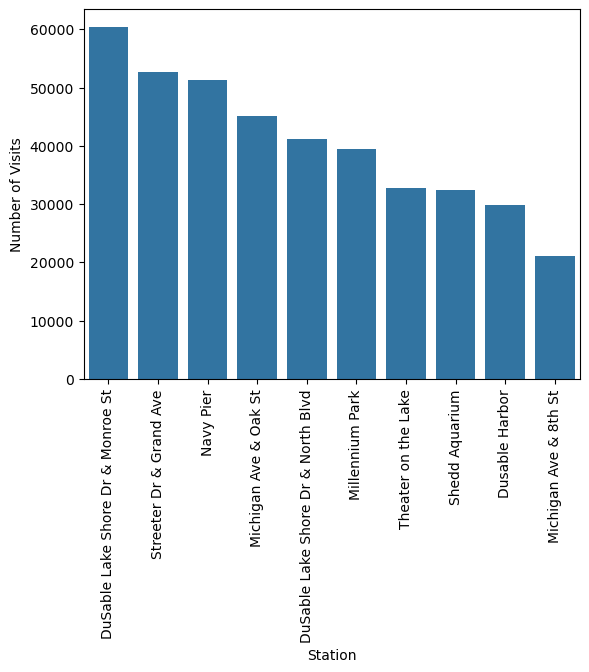

In [11]:
sns.barplot(
    data=most_frequented_stations_df,
    x="Station",
    y="Number of Visits"
)

plt.xticks(rotation=90)
plt.show()

Focusing the bulk of marketing resources on these ten docking stations may make it more likely to reach casual riders.

### Average Daily Trips by Month

Let's look at the average number of casual rides happening every month

In [12]:
month_numbers = casual_trips["started_at"].map(lambda timestamp: dt.datetime.fromisoformat(timestamp).month)

In [13]:
months = month_numbers.map({
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
})

In [14]:
month_num_days = pd.Series({
    "January": 31,
    "February": 28,
    "March": 31,
    "April": 30,
    "May": 31,
    "June": 30,
    "July": 31,
    "August": 31,
    "September": 30,
    "October": 31,
    "November": 30,
    "December": 31
})

In [15]:
avg_daily_rides = (casual_trips.groupby(months)["ride_id"].count() / month_num_days)[month_num_days.index]

In [16]:
avg_daily_rides

January        778.193548
February       991.321429
March         2769.741935
April         3641.300000
May           5895.806452
June          9733.533333
July         10430.709677
August       10899.290323
September     8842.266667
October       7225.741935
November      3102.066667
December      1238.903226
dtype: float64

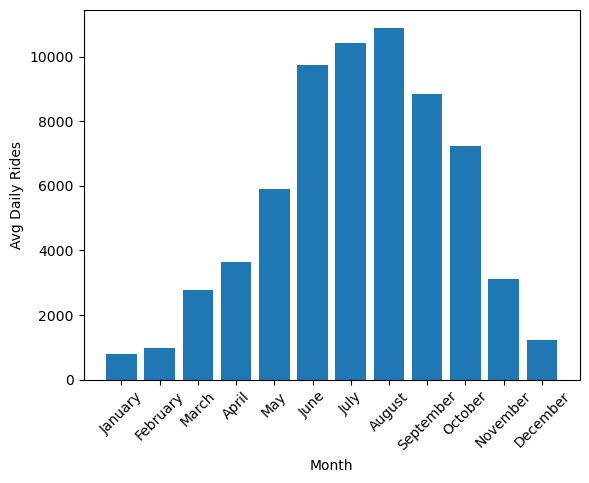

In [17]:
plt.bar(
    x=avg_daily_rides.index,
    height=avg_daily_rides.values
)

plt.xlabel("Month")
plt.ylabel("Avg Daily Rides")
plt.xticks(rotation=45)
plt.show()

From the plot, we see that, on average, the summer months (June, July, August) had the highest number of daily rides. A higher amount of marketing resources, therefore, might be focused on these months.

### Median Trip Duration by Month

In [41]:
def get_timestamp(timestamp_str):
    return dt.datetime.fromisoformat(timestamp_str)

In [42]:
trip_start_times = casual_trips["started_at"].map(get_timestamp)
trip_end_times = casual_trips["ended_at"].map(get_timestamp)

For some reason, some trips have an ending timestamp that's earlier in time than the starting timestamp.

In [20]:
casual_trips[trip_end_times < trip_start_times]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
6478,9E3880C1B94EAB39,electric_bike,2024-11-03 01:48:07.988,2024-11-03 01:08:20.603,Kingsbury St & Kinzie St,KA1503000043,Clark St & Schiller St,TA1309000024,41.889177,-87.638506,41.907993,-87.631501,casual
16319,61C2AE038C0D67AB,classic_bike,2024-11-03 01:25:33.243,2024-11-03 01:21:30.713,DuSable Lake Shore Dr & Monroe St,13300,Financial Pl & Ida B Wells Dr,SL-010,41.880958,-87.616743,41.875024,-87.633094,casual
34189,F147973D700AA375,electric_bike,2024-11-03 01:50:02.506,2024-11-03 01:03:37.247,Larrabee St & Oak St,KA1504000116,LaSalle Dr & Huron St,KP1705001026,41.900219,-87.642985,41.894877,-87.632326,casual
50444,F600DA96D6308ABF,electric_bike,2024-11-03 01:55:22.919,2024-11-03 01:00:36.080,Aberdeen St & Jackson Blvd,13157,Clinton St & Lake St,13021,41.877726,-87.654787,41.885637,-87.641823,casual
60851,BB4F8E728A4714E3,classic_bike,2024-11-03 01:55:10.885,2024-11-03 01:02:13.083,Clark St & Bryn Mawr Ave,KA1504000151,Damen Ave & Foster Ave,KA1504000149,41.983593,-87.669154,41.975811,-87.679510,casual
65231,5DD72265826A6FC0,classic_bike,2024-11-03 01:53:34.793,2024-11-03 01:11:24.271,Wilton Ave & Belmont Ave,TA1307000134,Broadway & Berwyn Ave,13109,41.940232,-87.652944,41.978361,-87.659789,casual
94659,76C64FC8024DA2AC,electric_bike,2024-11-03 01:54:39.214,2024-11-03 01:24:40.840,NaN,NaN,Wabash Ave & 16th St,SL-012,41.890000,-87.650000,41.860384,-87.625813,casual
99539,CB6B83A69815601E,classic_bike,2024-11-03 01:25:14.083,2024-11-03 01:21:26.779,DuSable Lake Shore Dr & Monroe St,13300,Financial Pl & Ida B Wells Dr,SL-010,41.880958,-87.616743,41.875024,-87.633094,casual
102513,BCD7AB1DE9ACBAB0,classic_bike,2024-11-03 01:48:42.787,2024-11-03 01:04:50.681,Milwaukee Ave & Wabansia Ave,13243,Milwaukee Ave & Rockwell St,13242,41.912616,-87.681391,41.920196,-87.692659,casual
112754,B4DFEDC4D2BCE650,classic_bike,2024-11-03 01:24:08.760,2024-11-03 01:21:28.841,DuSable Lake Shore Dr & Monroe St,13300,Financial Pl & Ida B Wells Dr,SL-010,41.880958,-87.616743,41.875024,-87.633094,casual


Unless the bike riders are somehow time-traveling, this seems to be a mistake. I'll not be taking these rows into consideration when calculating trip durations.

In [21]:
casual_trips = casual_trips[trip_start_times <= trip_end_times]

Now, we get the durations (i.e. difference between starting and ending times) for each trip in one place.

In [22]:
# recalculating with updated dataset
trip_start_times = casual_trips["started_at"].map(get_timestamp)
trip_end_times = casual_trips["ended_at"].map(get_timestamp)

In [23]:
durations = trip_end_times - trip_start_times

In [24]:
duration_minutes = durations.map(lambda duration: duration.total_seconds() / 60)

In [39]:
# taking the median since some ridiculously long trips skew the mean
median_monthly_trip_duration = duration_minutes.groupby(months).median()[month_num_days.index]

In [36]:
median_monthly_trip_duration

January       6.983917
February      7.223183
March        10.213258
April        10.336717
May          11.799575
June         12.823317
July         12.409825
August       12.871408
September    11.496775
October      10.269158
November      8.993383
December      7.991792
dtype: float64

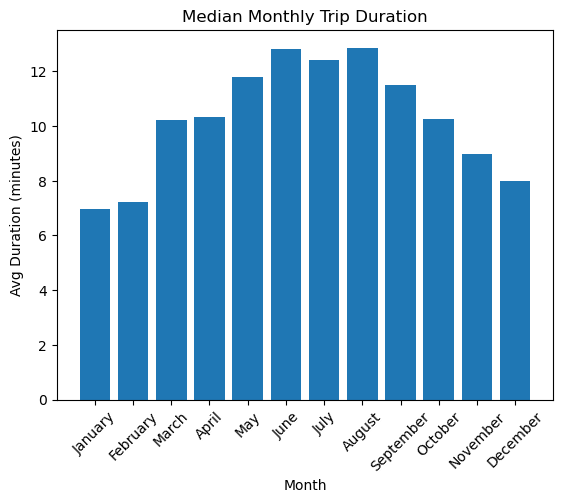

In [40]:
plt.bar(
    x=median_monthly_trip_duration.index,
    height=median_monthly_trip_duration.values
)

plt.xlabel("Month")
plt.ylabel("Avg Duration (minutes)")
plt.title("Median Monthly Trip Duration")

plt.xticks(rotation=45)
plt.show()

As with the average number of rides, the median duration of rides peaks in the summer months. This means casual riders, in general, are riding for longer at that time, and therefore may be more likely to come across billboards and the like.

### Average Trips by Weekday

In [55]:
trip_weekday_nums = trip_start_times.map(lambda timestamp: timestamp.weekday())

In [72]:
weekday_num_to_str = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

In [73]:
trip_weekdays = trip_weekday_nums.map(weekday_num_to_str)

In [74]:
# dividing by roughly the number of weeks in a year, 52, to get averages
avg_trips_by_weekday = (casual_trips.groupby(trip_weekdays)["ride_id"].count() / 52)[weekday_num_to_str.values()]

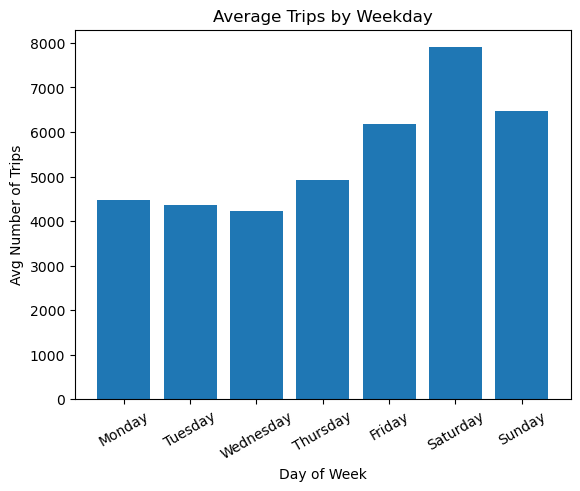

In [75]:
plt.bar(
    x=avg_trips_by_weekday.index,
    height=avg_trips_by_weekday.values
)

plt.xlabel("Day of Week")
plt.ylabel("Avg Number of Trips")
plt.title("Average Trips by Weekday")

plt.xticks(rotation=30)
plt.show()

More casual trips happen on the weekends, on average.

### Median Trip Duration by Weekday

In [76]:
median_trip_duration_by_weekday = duration_minutes.groupby(trip_weekdays).median()[weekday_num_to_str.values()]

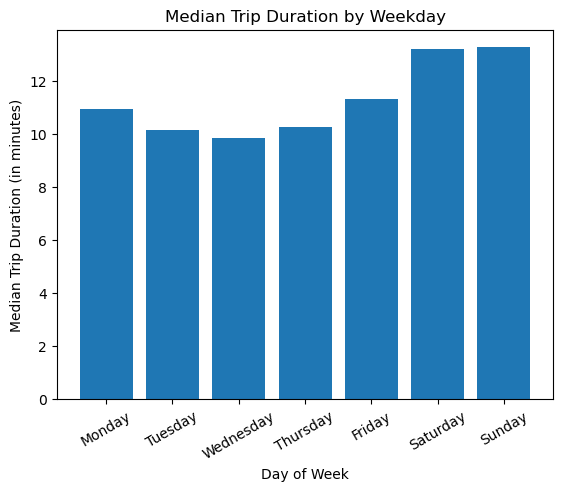

In [78]:
plt.bar(
    x=median_trip_duration_by_weekday.index,
    height=median_trip_duration_by_weekday.values
)

plt.xlabel("Day of Week")
plt.ylabel("Median Trip Duration (in minutes)")
plt.title("Median Trip Duration by Weekday")

plt.xticks(rotation=30)
plt.show()

Median trip duration on the weekends is slightly higher.

## Marketing Strategy

To maximize conversions of casual riders to annual members, it might be useful to focus marketing resources on the top ten docking stations mentioned earlier, especially in th|e summer months and on the weekends, since it is at these places and times that casual riders may be most likely to come across advertisements for an annual membership.